In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py

In [2]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('.gitignore')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  167


['permutations/total_ring_mass=9.653488644416229e-10_radial_width=0.0005_shear_viscosity=1.7740669461678767e-10_sim_id=38_timesteps_per_output=8_',
 'permutations/total_ring_mass=4.999999999999994e-10_radial_width=0.0005_shear_viscosity=2.8117066259517428e-12_sim_id=5_timesteps_per_output=293_',
 'permutations/total_ring_mass=2.5897373396156115e-08_radial_width=0.0005_shear_viscosity=2.8117066259517428e-12_sim_id=131_timesteps_per_output=15197_',
 'permutations/total_ring_mass=9.653488644416229e-10_radial_width=0.0005_shear_viscosity=1.2559432157547869e-10_sim_id=37_timesteps_per_output=12_',
 'permutations/total_ring_mass=9.653488644416229e-10_radial_width=0.0005_shear_viscosity=1.4091914656322246e-12_sim_id=24_timesteps_per_output=1130_']

In [3]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import pandas as pd

In [4]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('_timesteps_per_output=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

sim_id                                               path
0       0  permutations/total_ring_mass=4.999999999999994...
1       1  permutations/total_ring_mass=4.999999999999994...
2       2  permutations/total_ring_mass=4.999999999999994...
3       3  permutations/total_ring_mass=4.999999999999994...
4       4  permutations/total_ring_mass=4.999999999999994...

In [5]:
#set power laws for ringlet's dynamical timescale = time for e_prime to reach 0.6, which is assumed to vary as 
#(ringlet_mass**mass_power_law)*(viscosity**viscosity_power_law)*(radial_width**width_power_law)
nominal_dynamical_timescale = 1.65e4
mass_power_law = 1.0
viscosity_power_law = -1.0
width_power_law = -0.33

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:56: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:58: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:68: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)


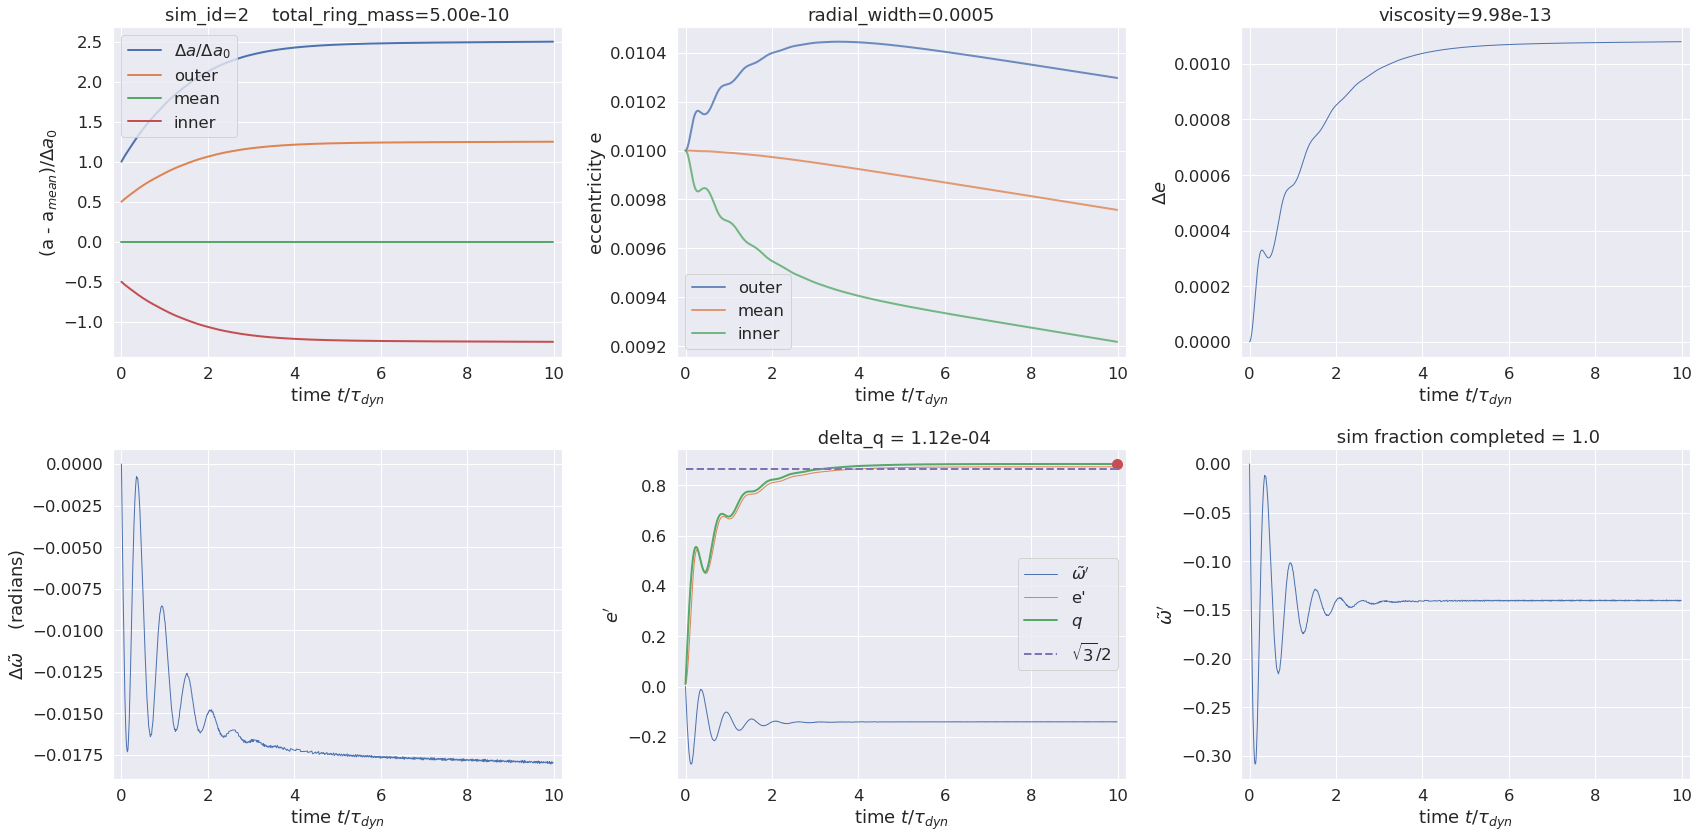

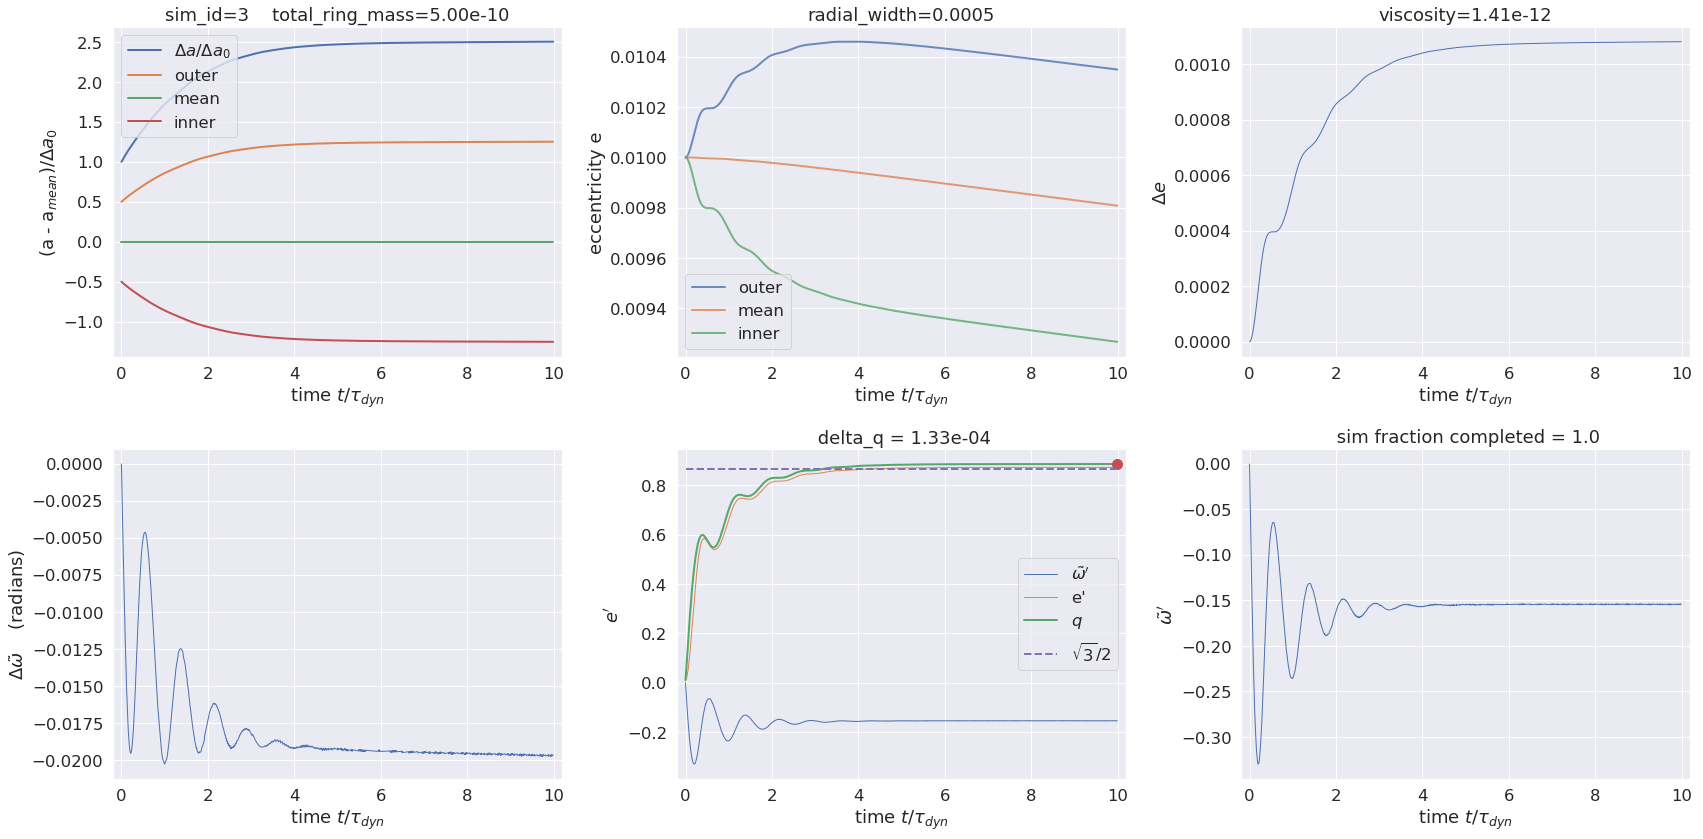

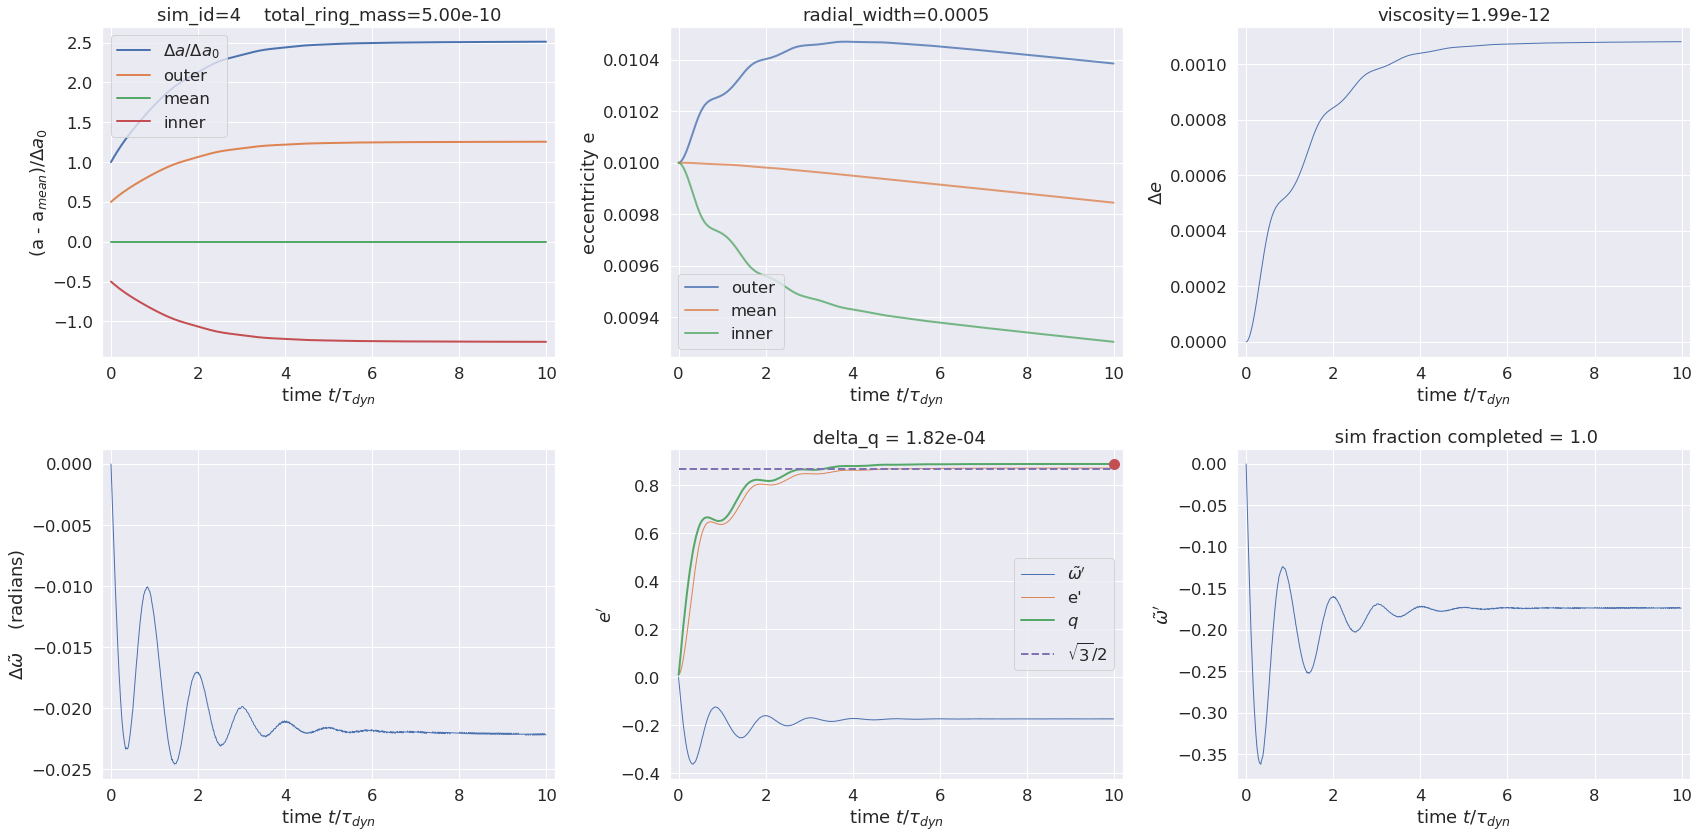

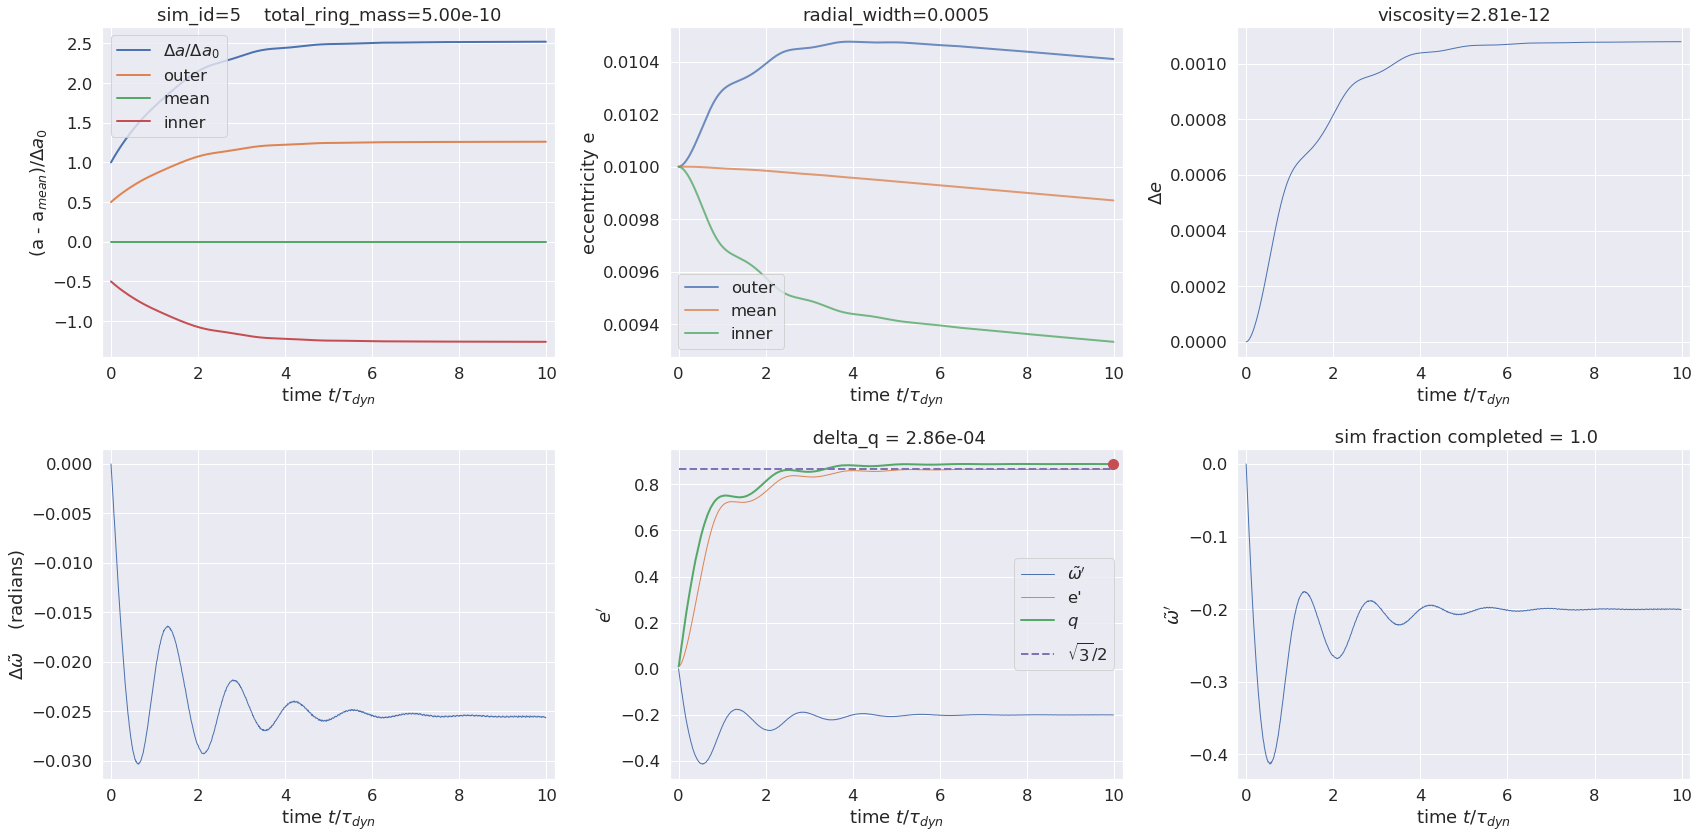

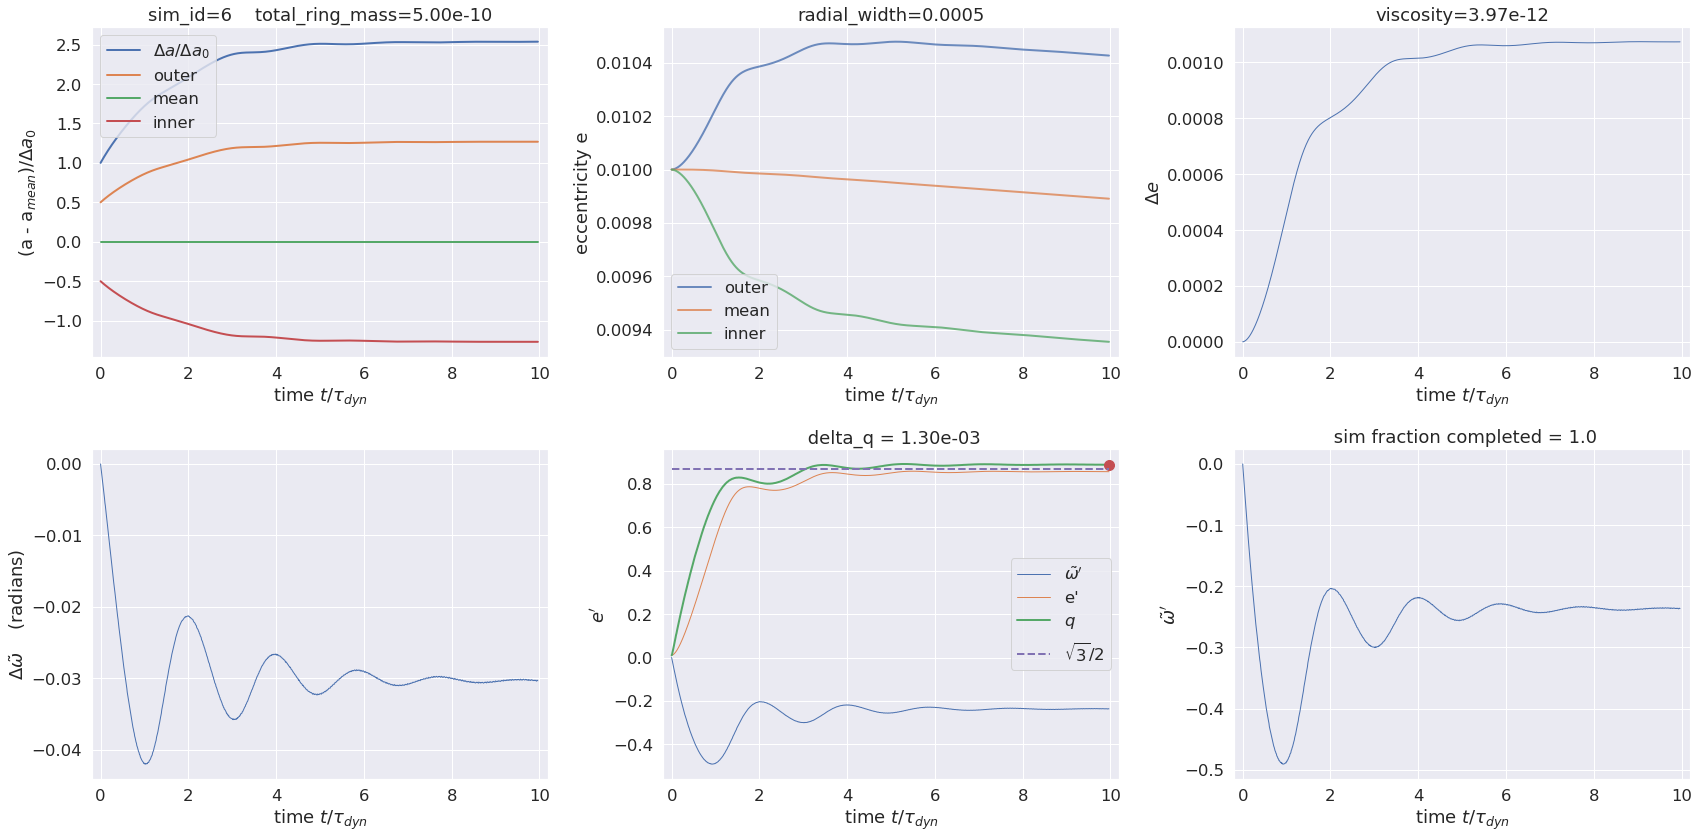

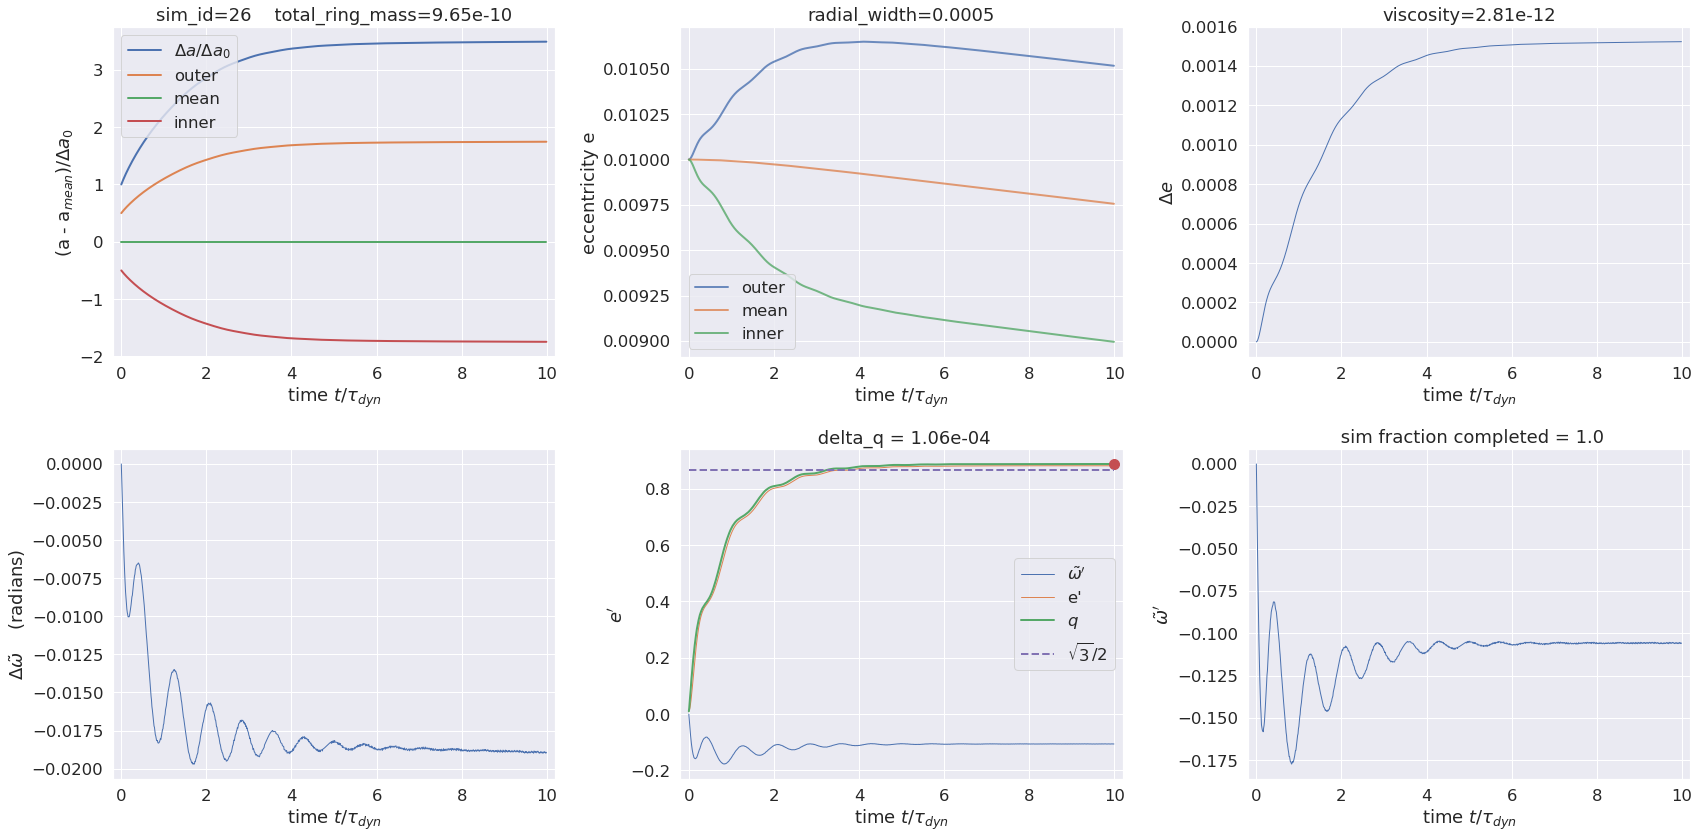

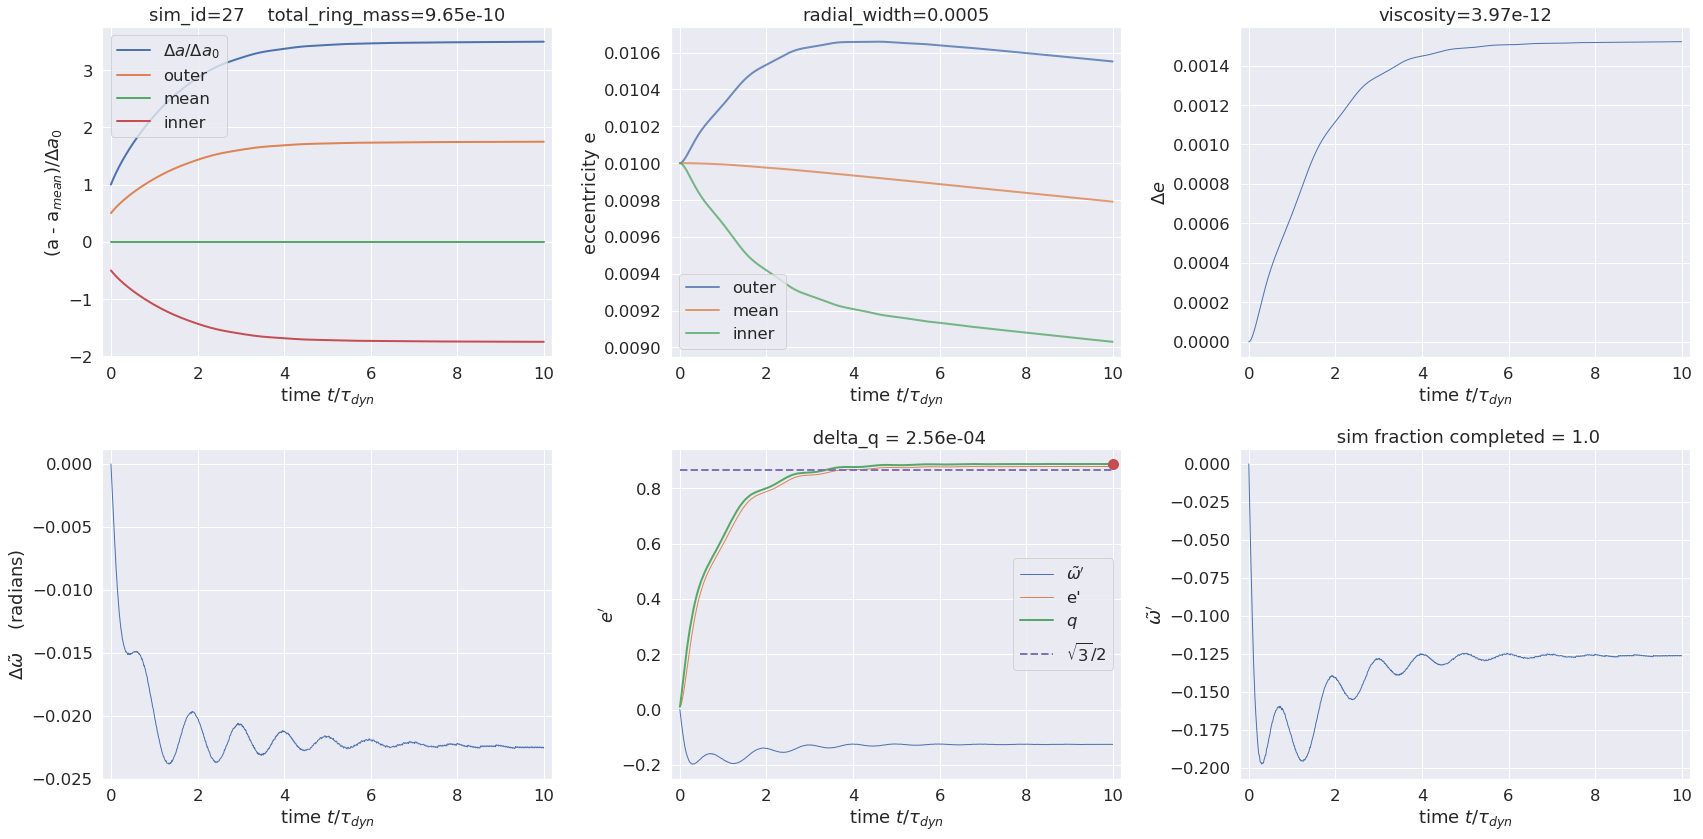

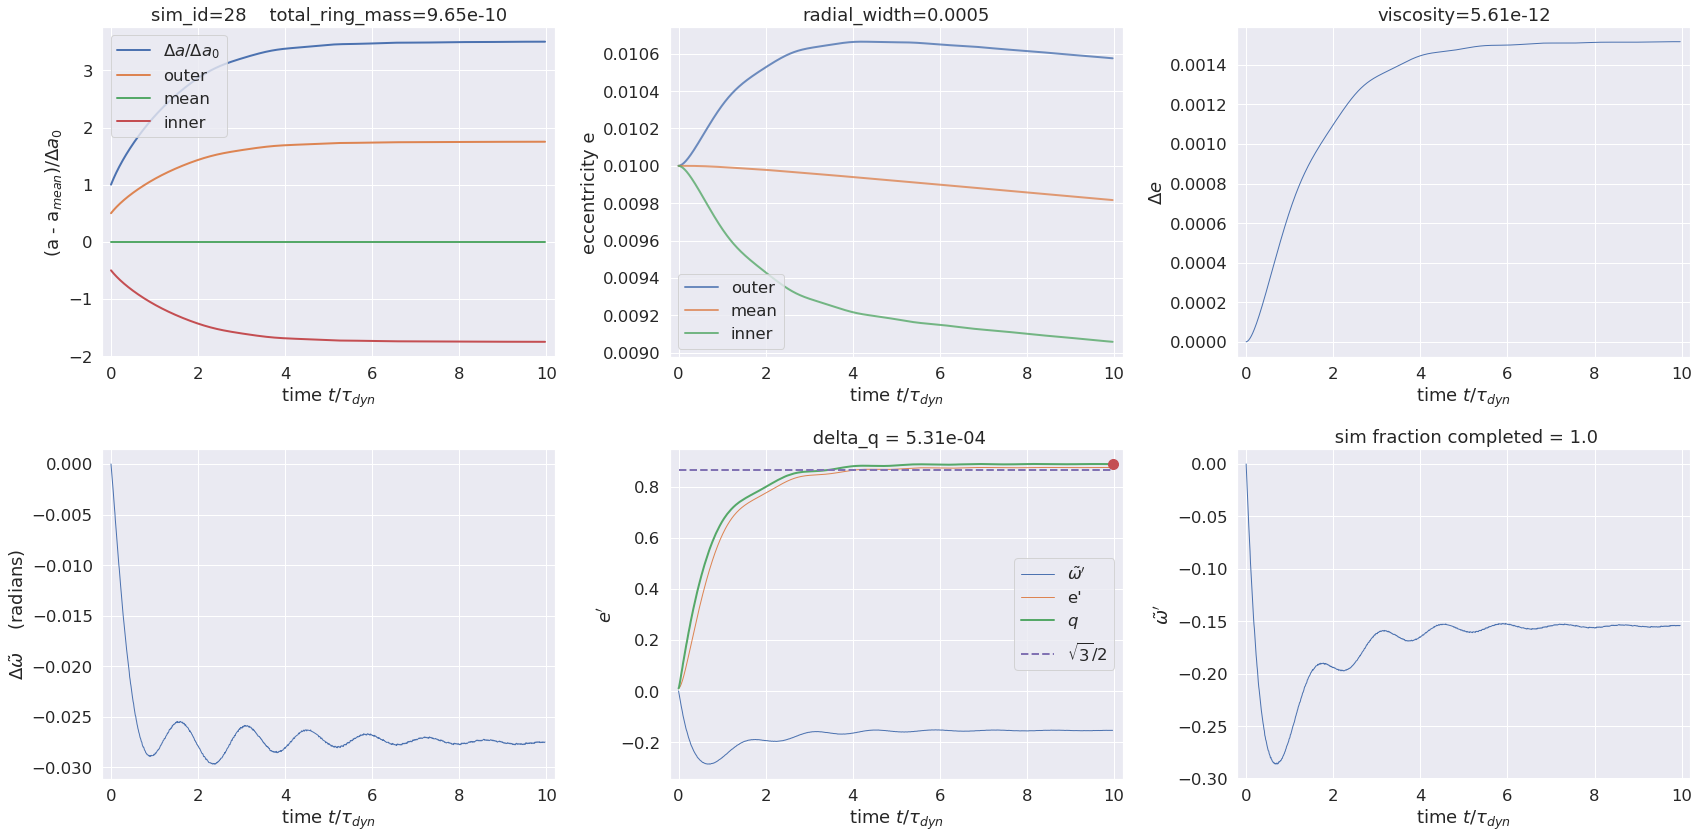

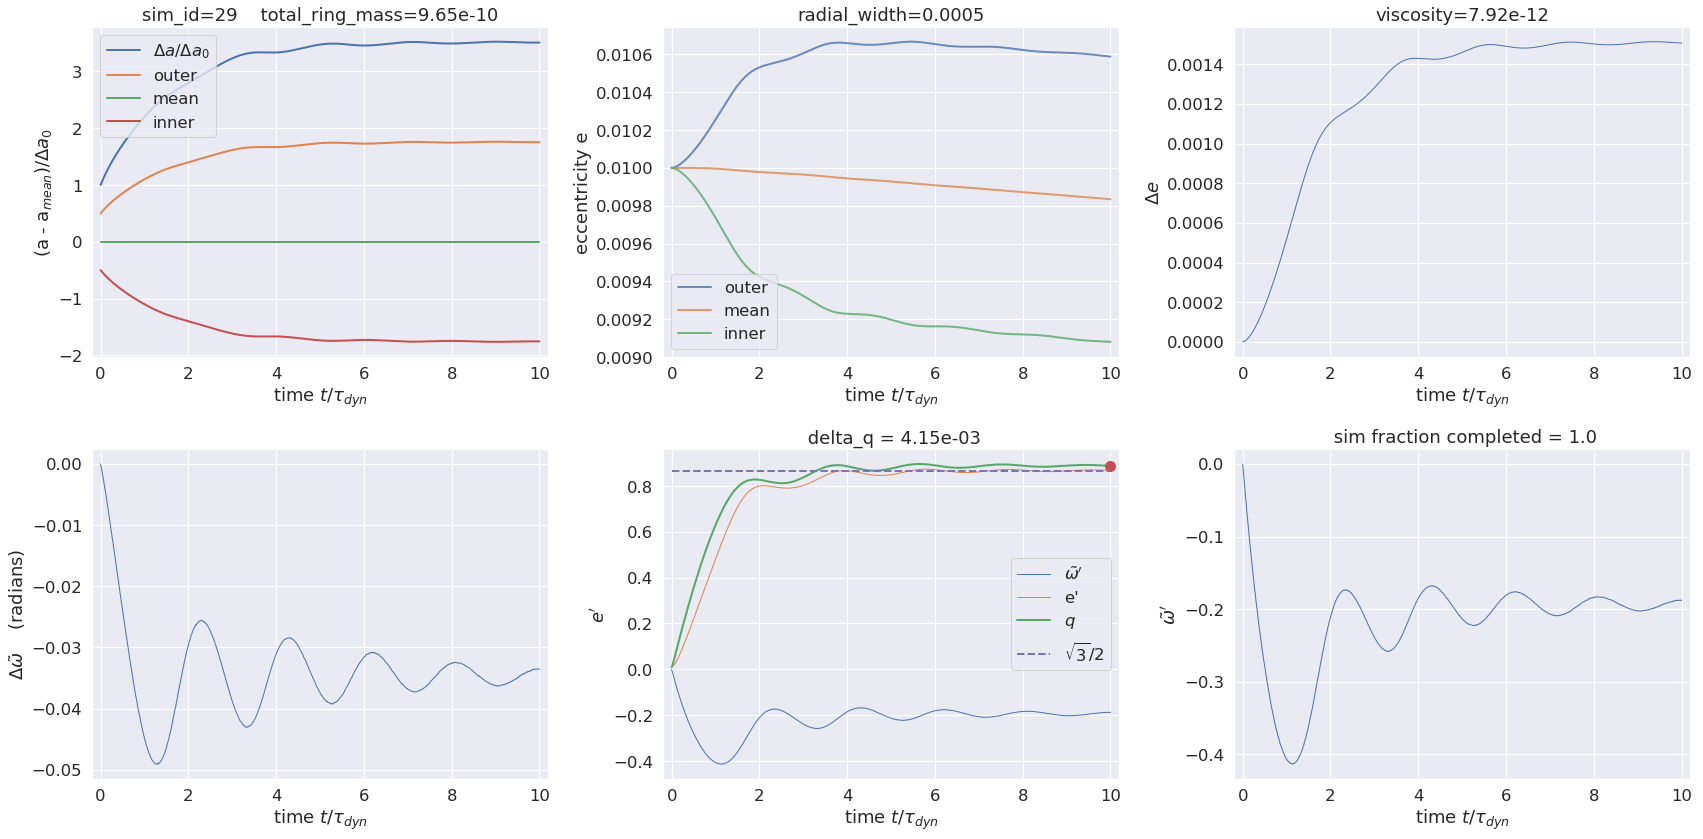

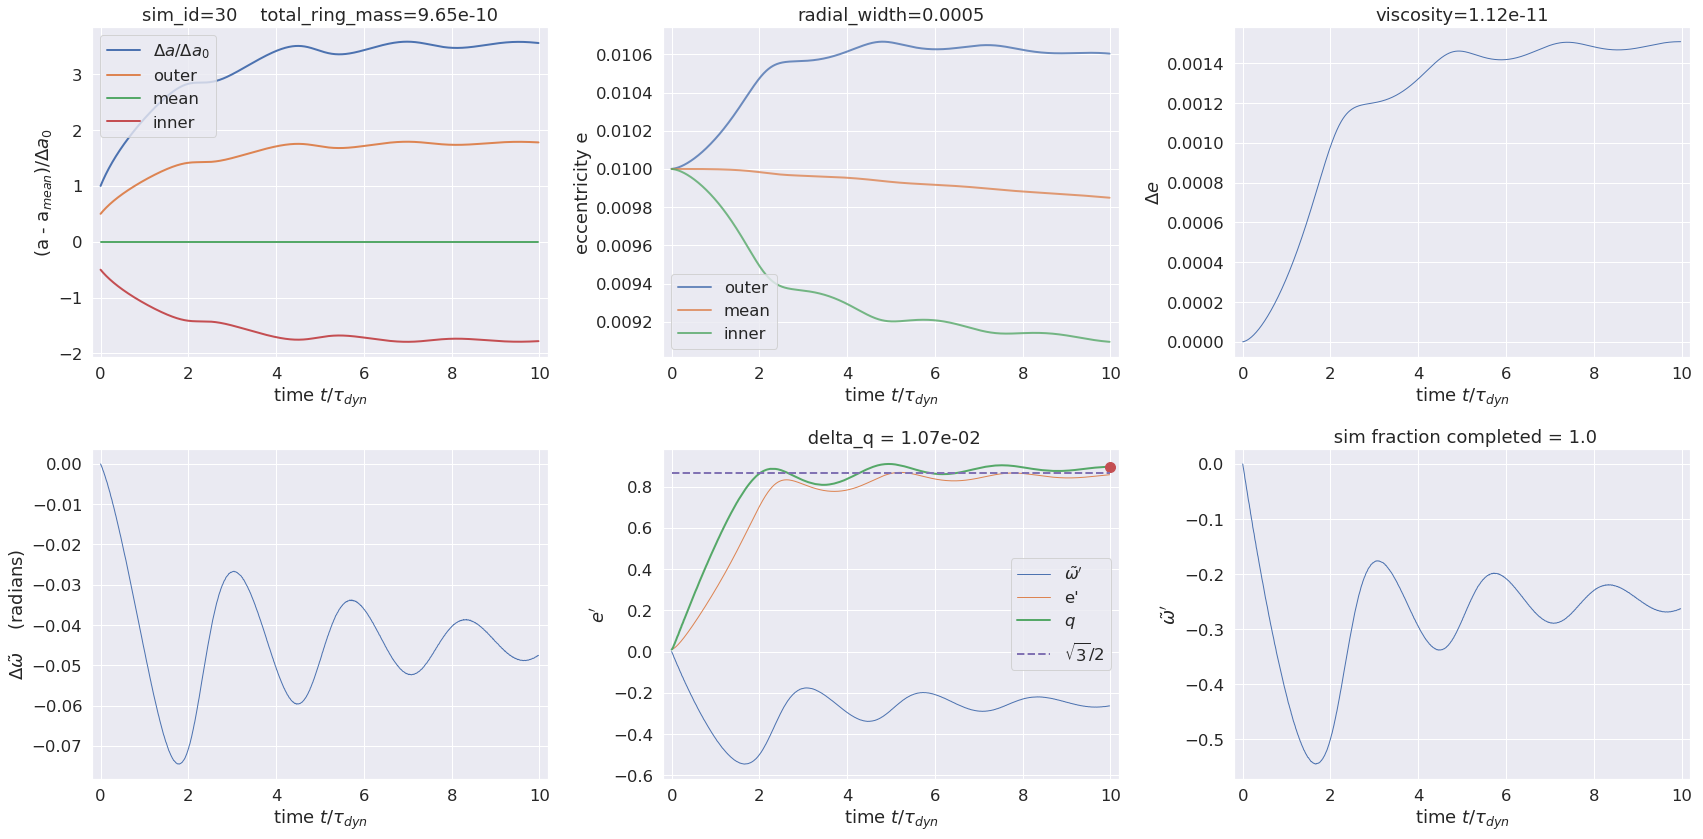

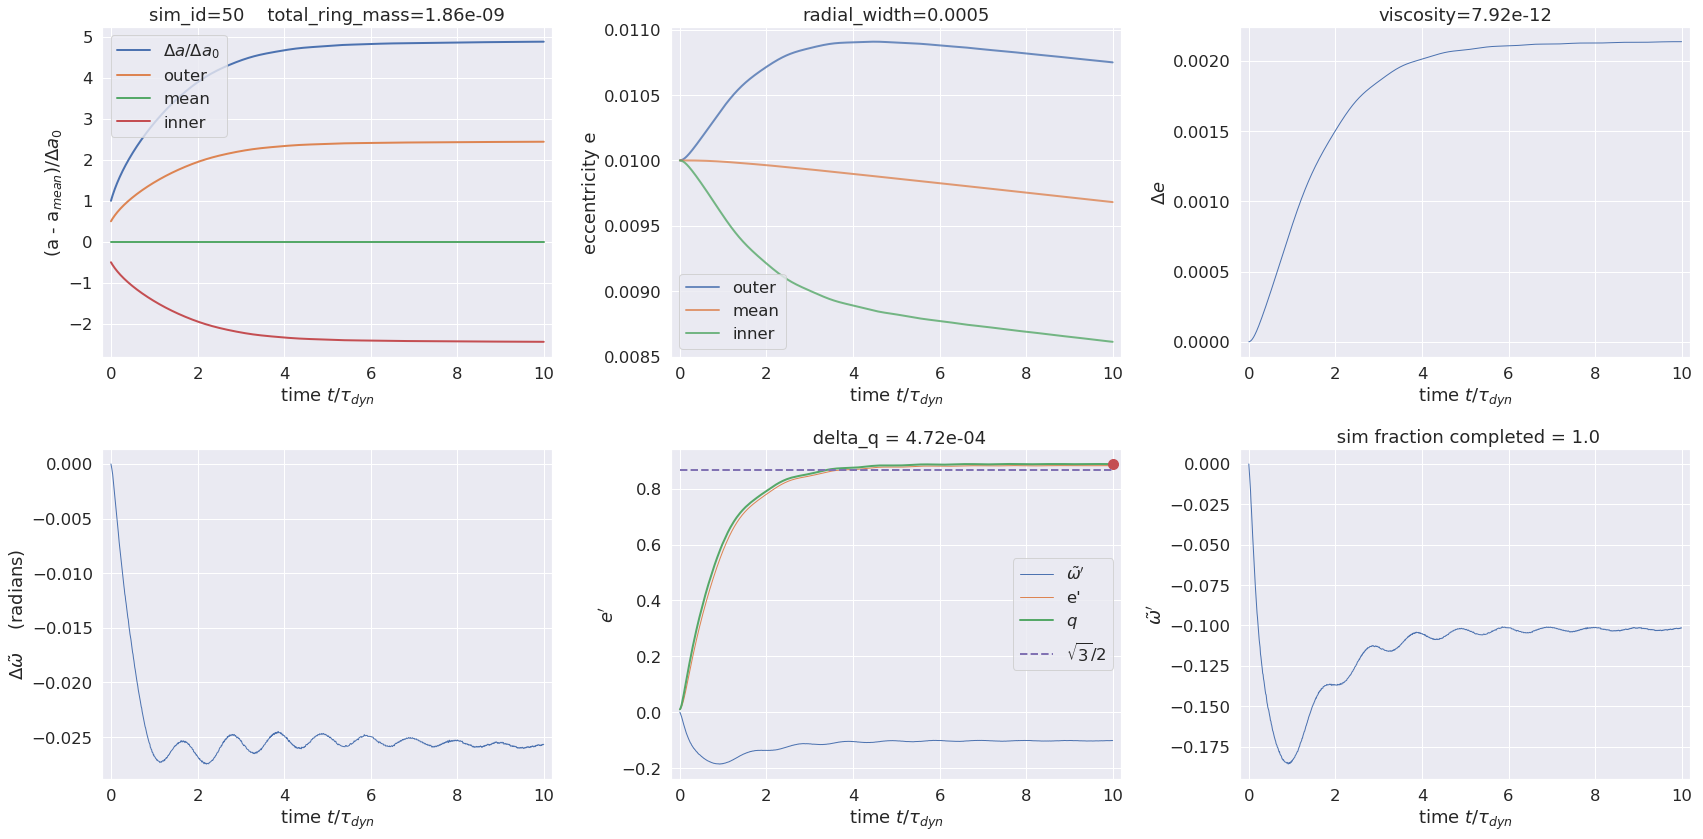

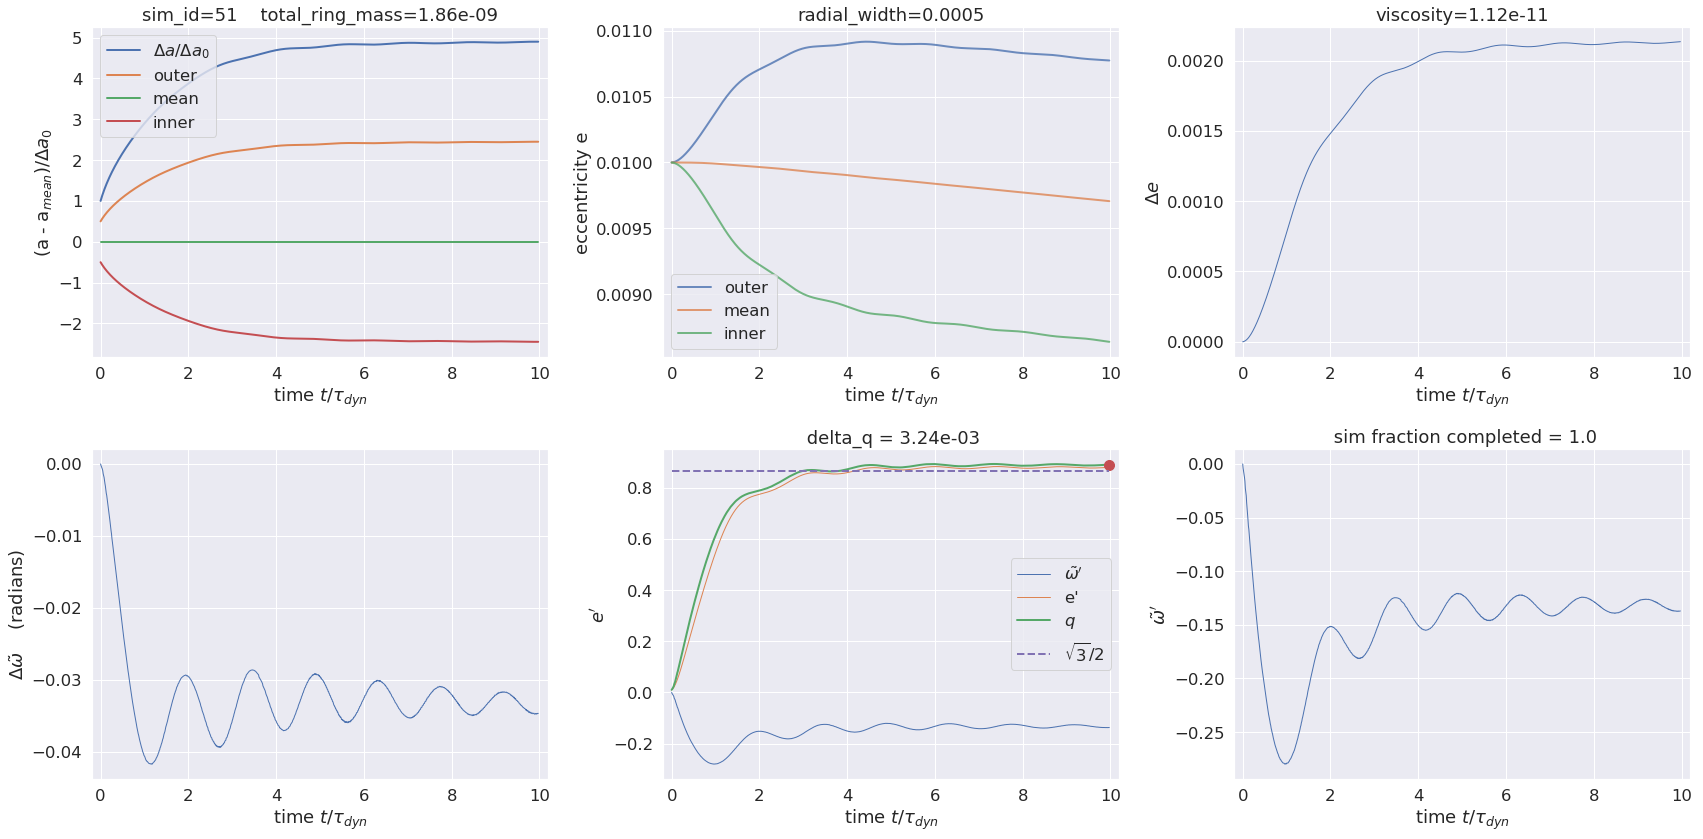

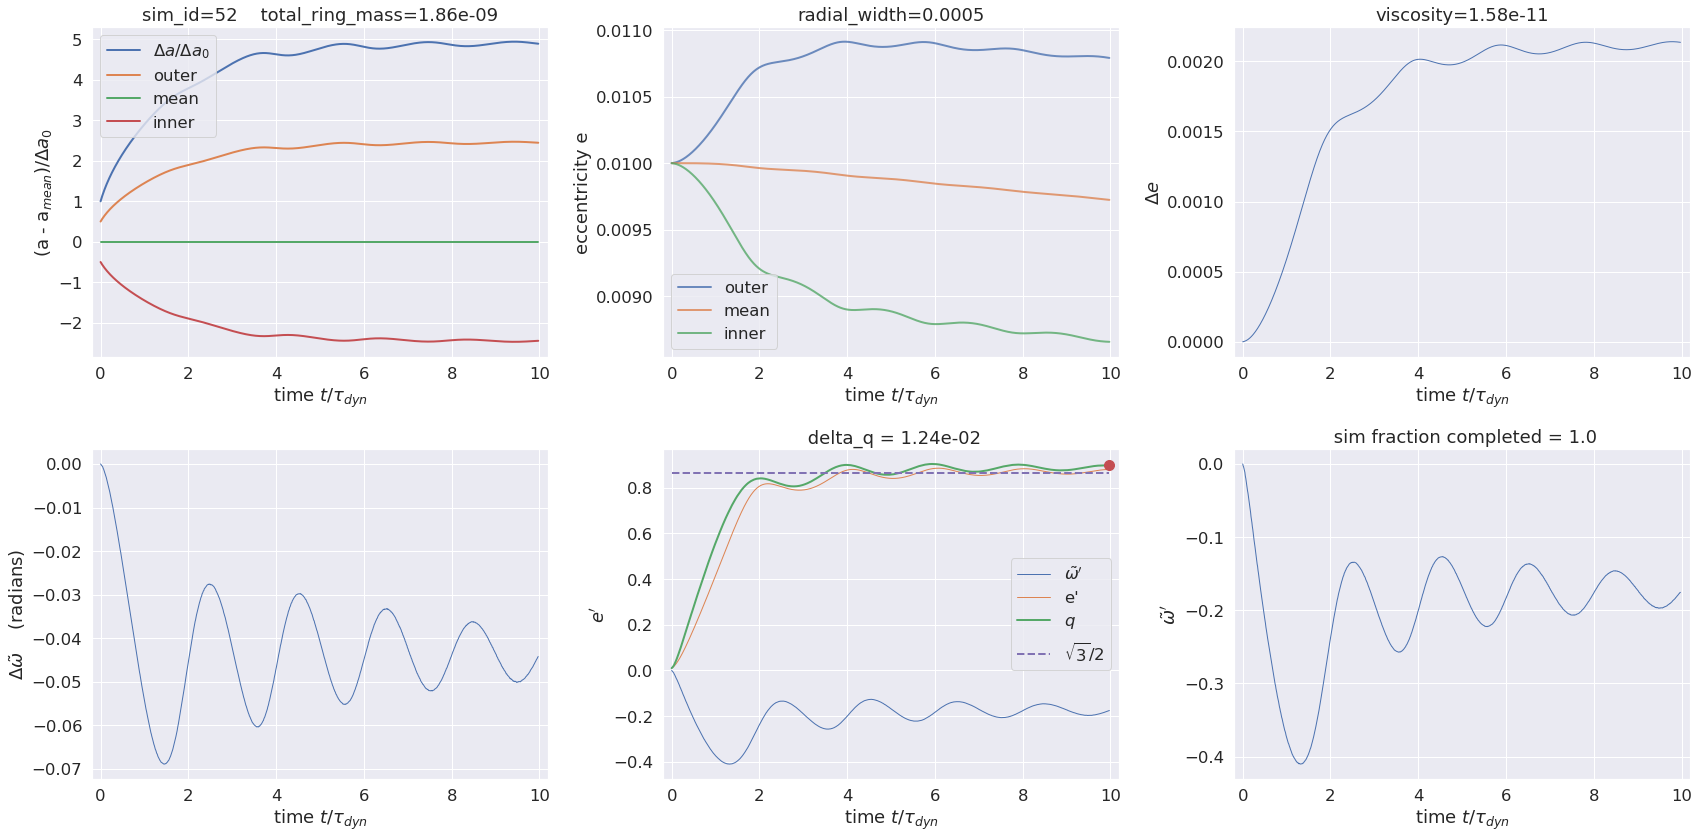

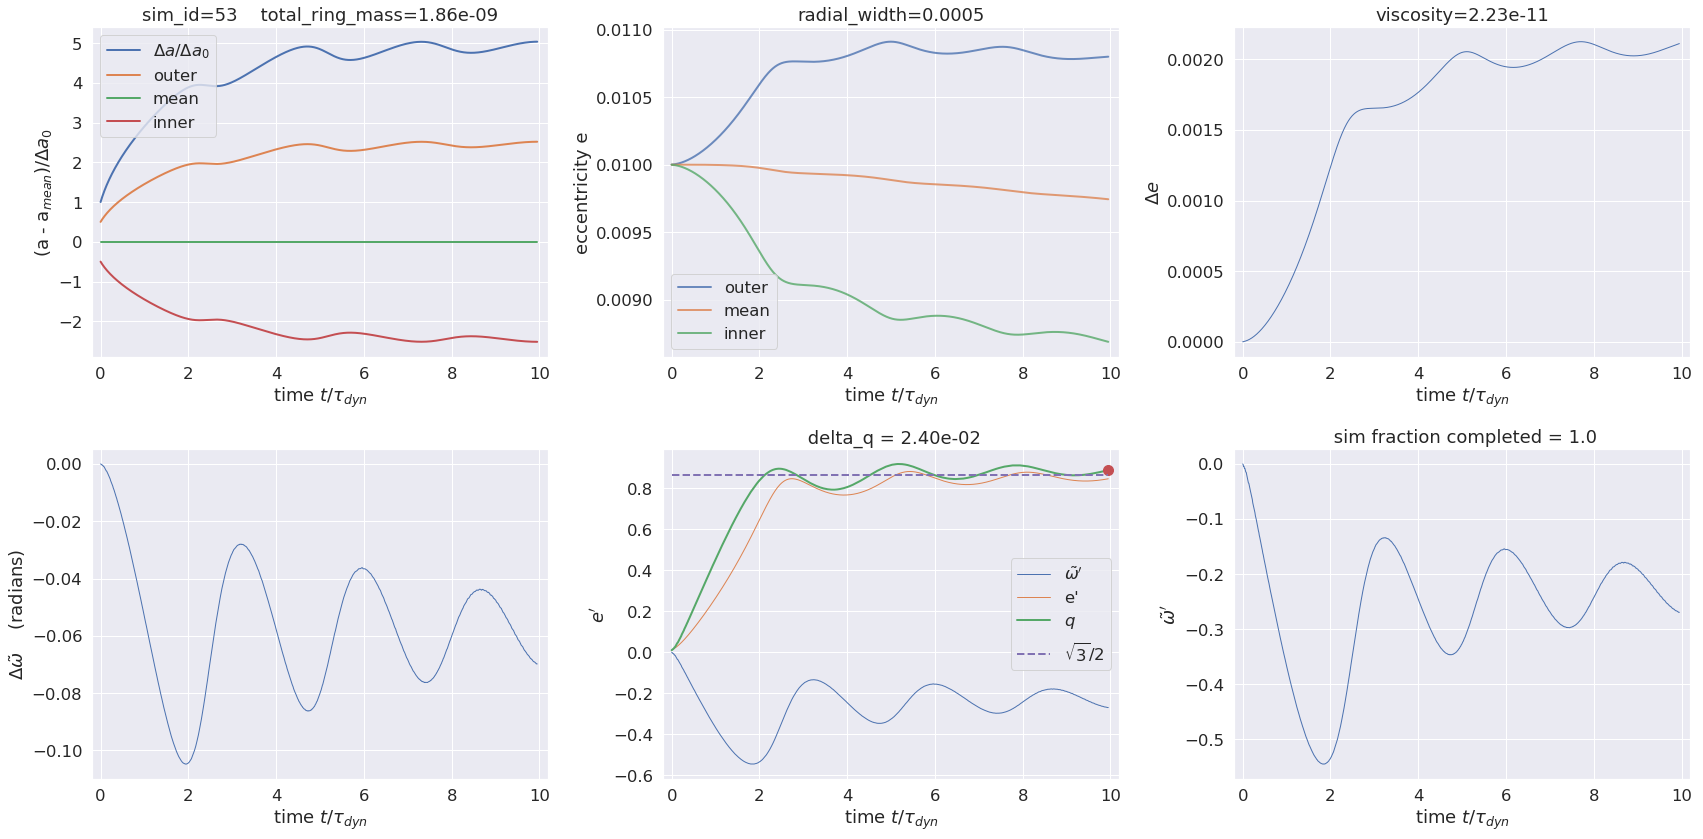

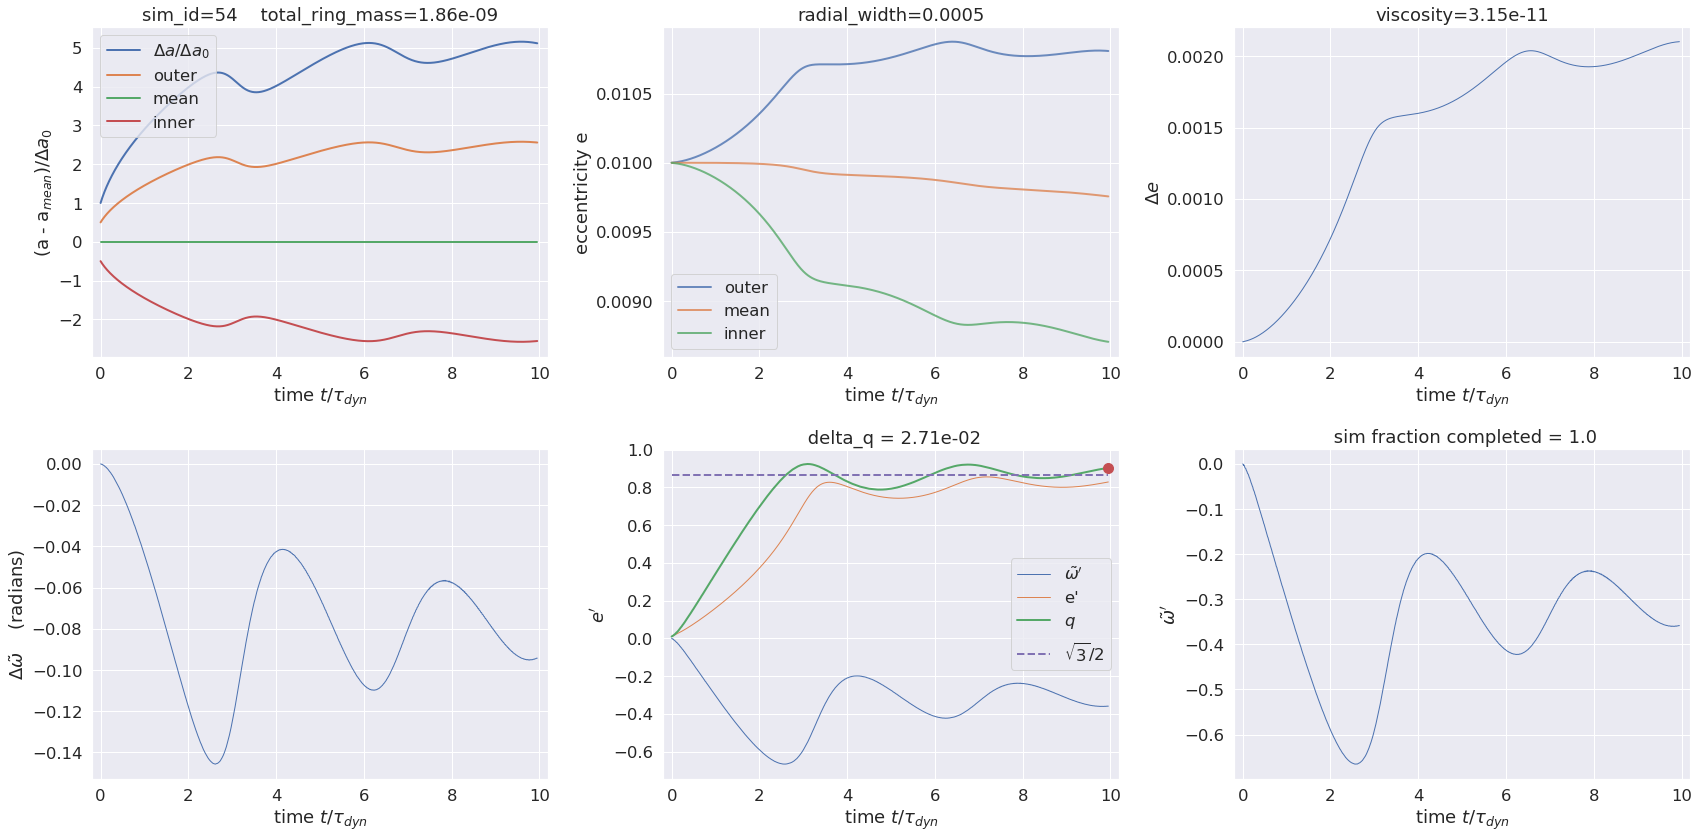

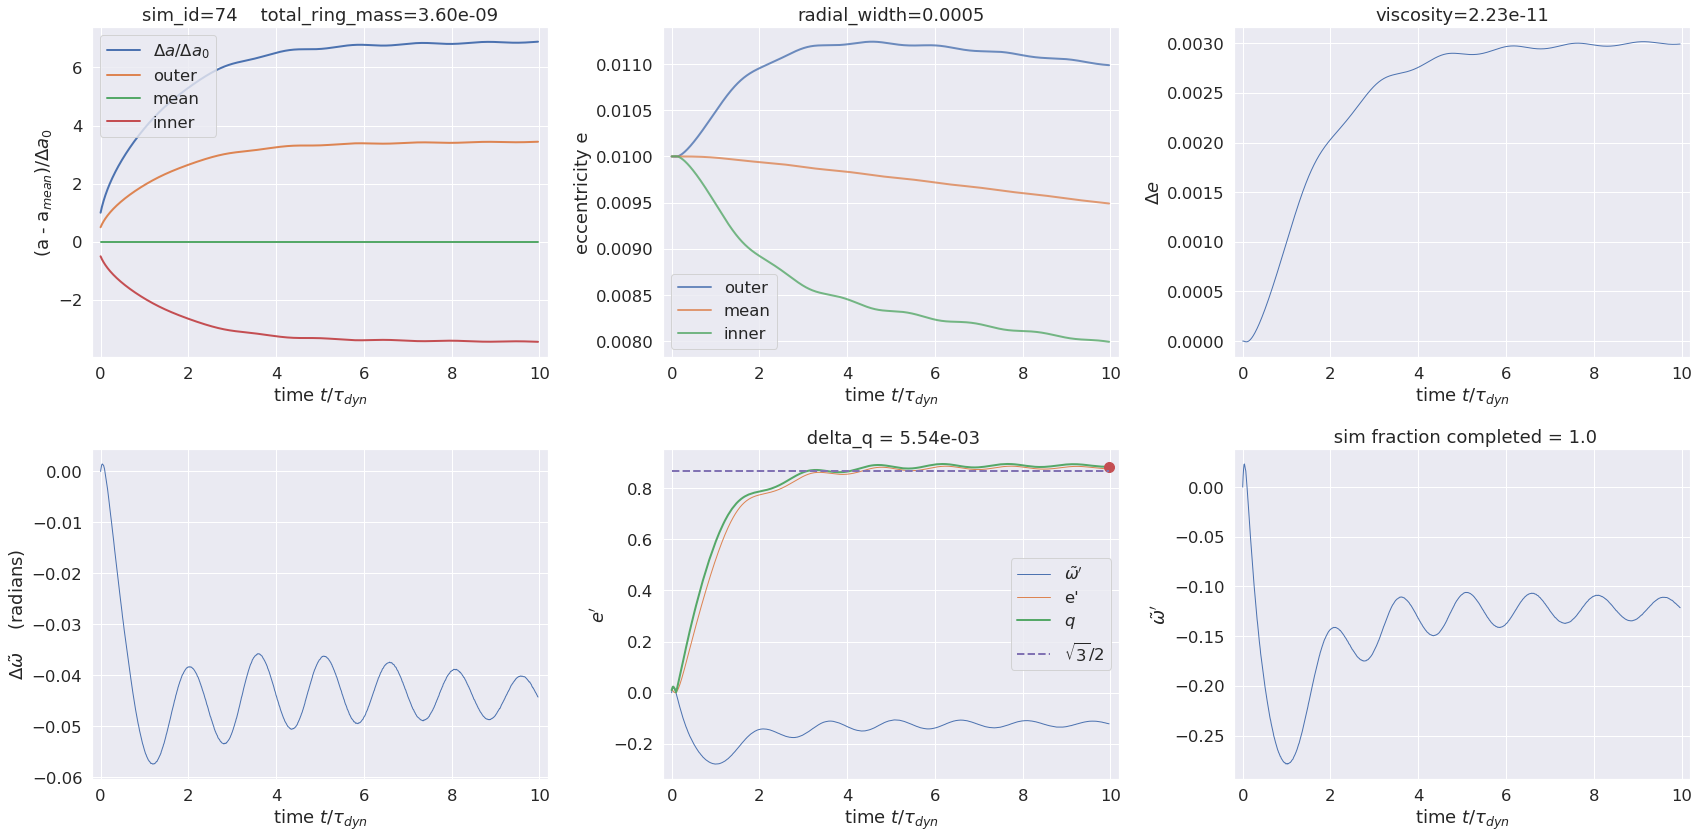

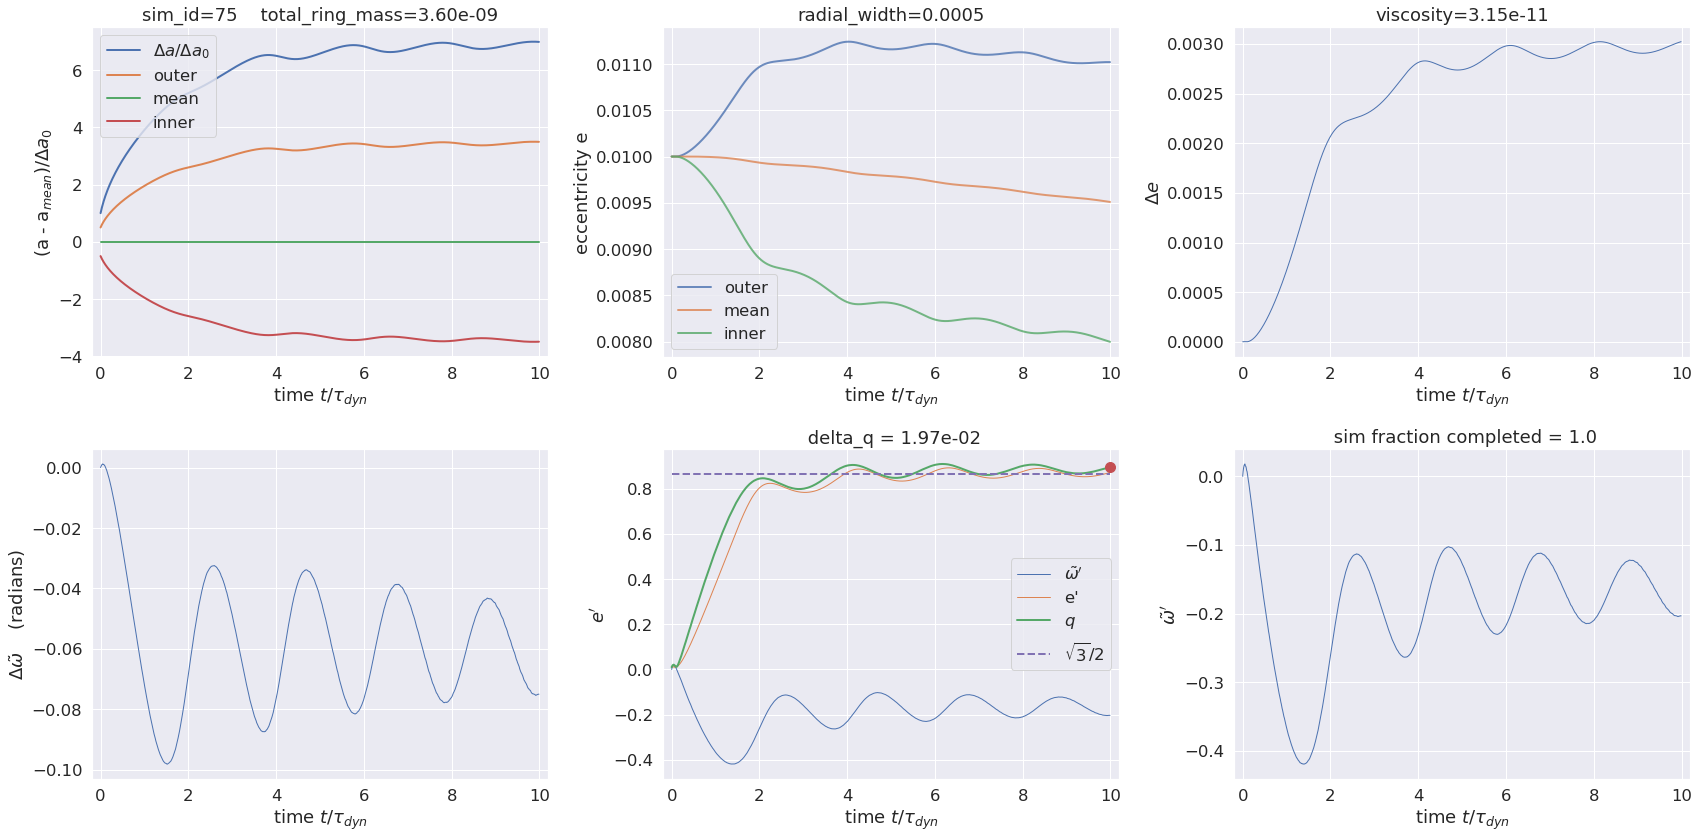

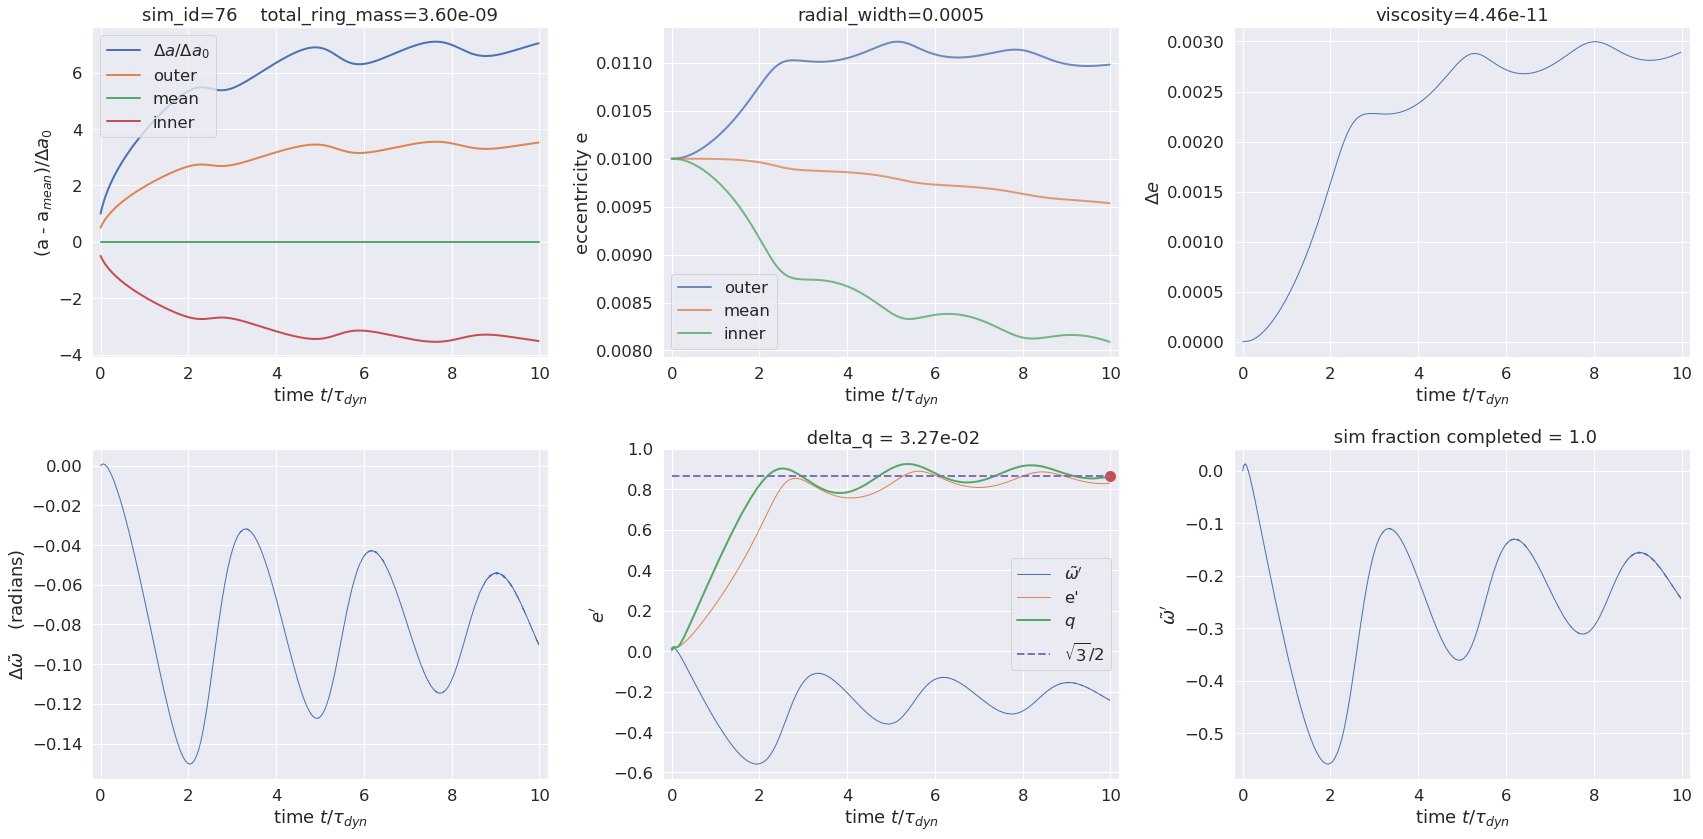

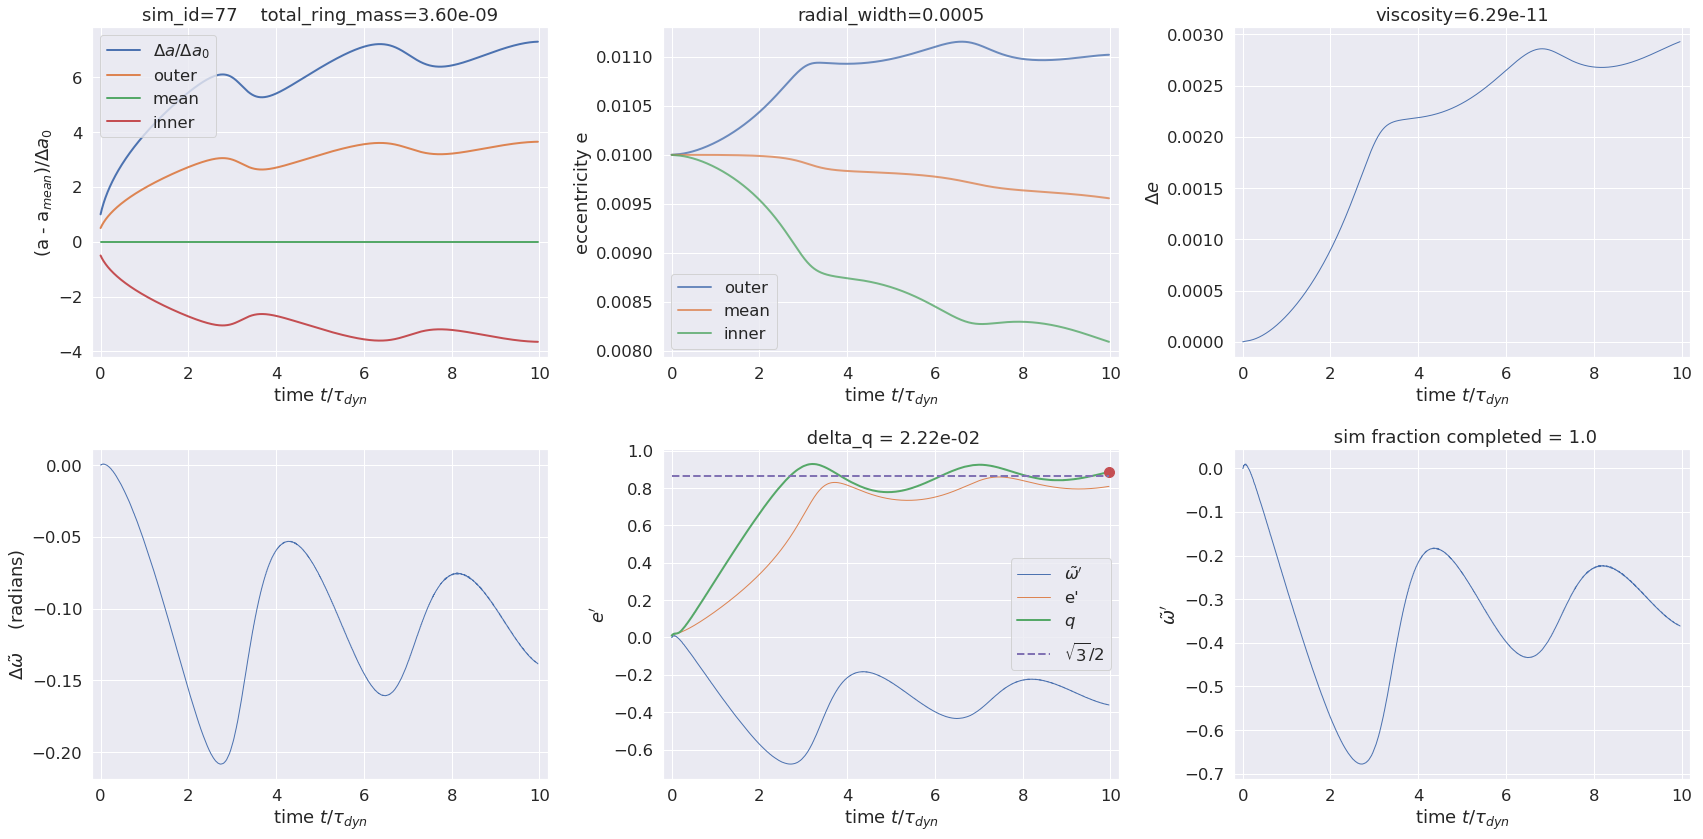

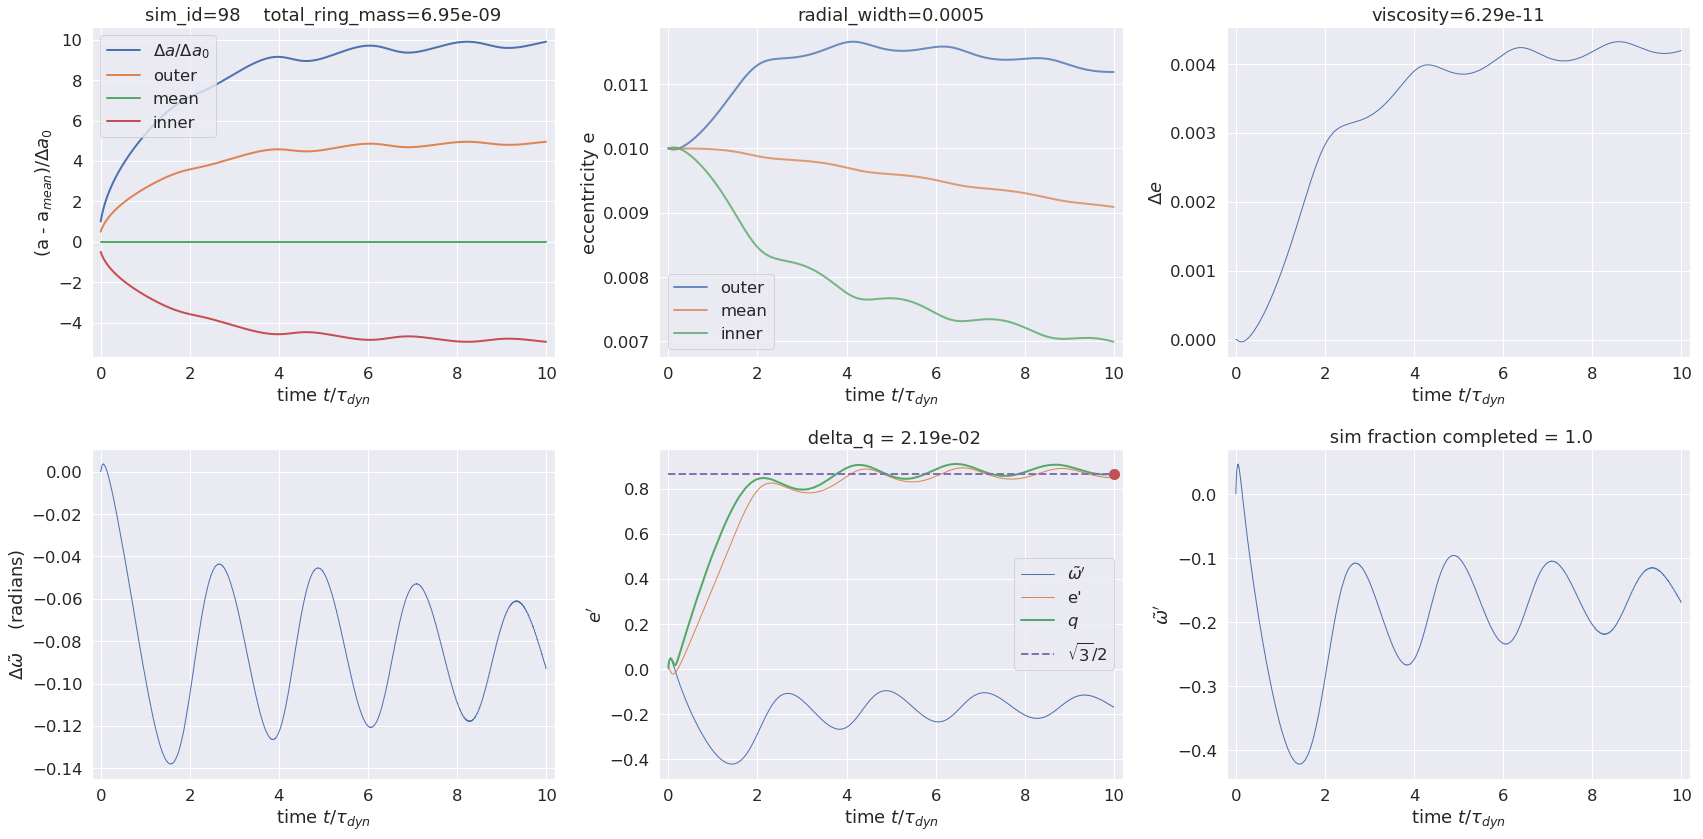

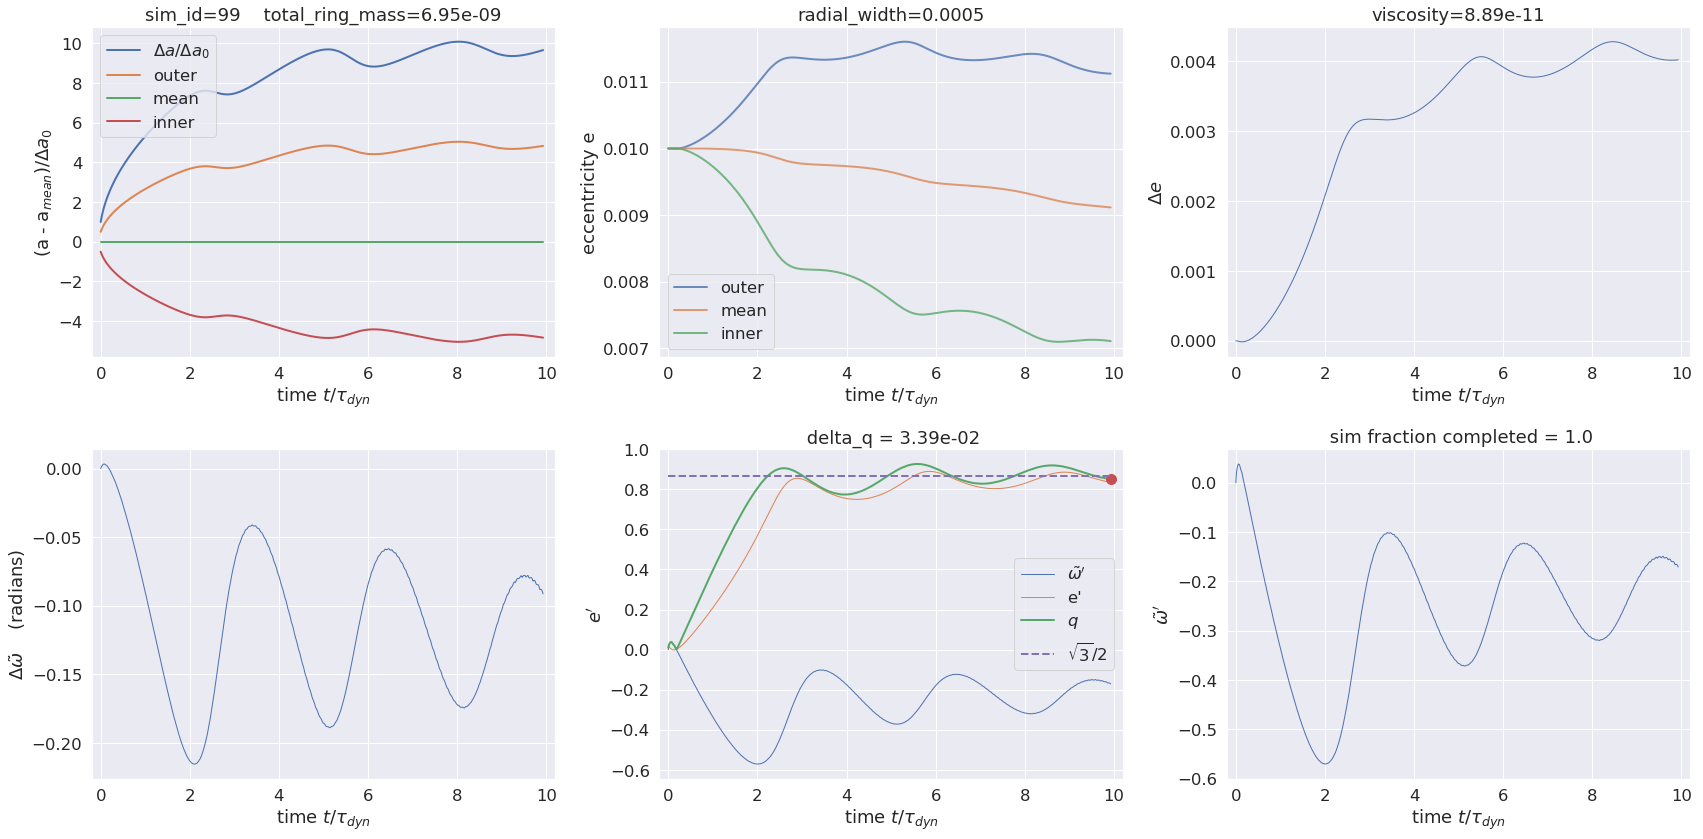

In [6]:
#generate grid of summary plots, for each sim that evolves to completion with low |wt_prime|
debug = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    d['times_dynamical_max'] = int(times_dynamical.max())
    
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    da_init = da[0]
    
    #compute e_prime, wt_prime, q to lowest order, and H(q)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    idx = (times_dynamical > 0.8*times_dynamical.max())
    d['q'] = q[idx].mean()
    d['delta_q'] = 0.5*(q[idx].max() - q[idx].min())
    d['wt_prime'] = wt_prime[idx].mean()
    
    #report on sims that execute without crossing streamlines
    if ((current_timestep == expected_timestep) and (np.abs(d['wt_prime']) < d['q']/2)):

        if (debug):
            print 'path = ', path
            print 'total_ring_mass = ', total_ring_mass
            print 'radial_width = ', radial_width
            print 'shear_viscosity = ', shear_viscosity
            print 'dynamical_timescale = ', dynamical_timescale
            print 'current, expected timesteps = ', current_timestep, expected_timestep
            print 'execution time (minutes) = ', (monitor['current_time'] - monitor['start_time'])/60.0
        
        #create grid of plots
        sns.set(font_scale=1.5, font='DejaVu Sans')
        fig, axs = plt.subplots(2, 3, figsize=(24, 12))
        
        #plot streamline's mutual a-evolution
        ax = axs[0][0]
        x = times_dynamical
        y = da/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a/\Delta a_0$')
        y = (a_outer - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='outer')
        y = (a_mean - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='mean')
        y = (a_inner - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
        title = 'sim_id=' + str(sim_id) + '    total_ring_mass=' + '{:.2e}'.format(total_ring_mass)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()

        #plot streamline's e-evolution
        ax = axs[0][1]
        x = times_dynamical
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        title = 'radial_width=' + str(radial_width)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot delta_e versus time
        ax = axs[0][2]
        x = times_dynamical
        y = de
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta e$')
        title = 'viscosity=' + '{:.2e}'.format(shear_viscosity)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot dwt versus time
        ax = axs[1][0]
        x = times_dynamical
        y = dwt
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta\tilde{\omega}$    (radians)')
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot e_prime wt_prime and q versus time
        ax = axs[1][1]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        if (streamline_crossing_timestep == None):
            p = ax.plot(x[-1], y[-1], marker='o', markersize=10, label='')
        p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
        title = ' delta_q = ' + '{:.2e}'.format(d['delta_q'])
        p = ax.set_title(title)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot wt_prime versus time
        ax = axs[1][2]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        title = ' sim fraction completed = ' + str(current_timestep*1.0/expected_timestep)
        p = ax.set_title(title)

        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$\tilde{\omega}'$")
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
    
    data += [d]
df = pd.DataFrame(data)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'times_dynamical_max', 
    'total_ring_mass', 'radial_width', 'shear_viscosity', 'q', 'delta_q', 'wt_prime', 'path']
df = df[cols].sort_values('sim_id').reset_index(drop=True)
df_results = df

In [7]:
#list all sims that evolved into self-confining state
df = df_results
idx = (df.current_timestep == df.expected_timestep)
print 'fraction of sims that execute to completion = ', idx.sum()*1.0/len(idx)
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() < df.q/2)
print 'fraction of sims that evolve to self-confining state = ', idx.sum()*1.0/len(idx)
df[idx]

fraction of sims that execute to completion =  0.2634730538922156
fraction of sims that evolve to self-confining state =  0.12574850299401197


sim_id  expected_timestep  current_timestep  streamline_crossing_timestep  \
2        2             826000            826000                           NaN   
3        3             585000            585000                           NaN   
4        4             414000            414000                           NaN   
5        5             293000            293000                           NaN   
6        6             207000            207000                           NaN   
26      26             566000            566000                           NaN   
27      27             401000            401000                           NaN   
28      28             283000            283000                           NaN   
29      29             201000            201000                           NaN   
30      30             142000            142000                           NaN   
50      50             388000            388000                           NaN   
51      51             274000            274000                           NaN   
52      52             194000            194000                           NaN   
53      53             137000            137000                           NaN   
54      54              97000             97000                           NaN   
74      74             265000            265000                           NaN   
75      75             188000            188000                           NaN   
76      76             133000            133000                           NaN   
77      77              94000             94000                           NaN   
98      98             182000            182000                           NaN   
99      99             128000            128000                           NaN   

    times_dynamical_max  total_ring_mass  radial_width  shear_viscosity  \
2                     9     5.000000e-10        0.0005     9.976312e-13   
3                     9     5.000000e-10        0.0005     1.409191e-12   
4                     9     5.000000e-10        0.0005     1.990536e-12   
5                     9     5.000000e-10        0.0005     2.811707e-12   
6                     9     5.000000e-10        0.0005     3.971641e-12   
26                    9     9.653489e-10        0.0005     2.811707e-12   
27                    9     9.653489e-10        0.0005     3.971641e-12   
28                    9     9.653489e-10        0.0005     5.610092e-12   
29                    9     9.653489e-10        0.0005     7.924466e-12   
30                    9     9.653489e-10        0.0005     1.119361e-11   
50                    9     1.863797e-09        0.0005     7.924466e-12   
51                    9     1.863797e-09        0.0005     1.119361e-11   
52                    9     1.863797e-09        0.0005     1.581139e-11   
53                    9     1.863797e-09        0.0005     2.233418e-11   
54                    9     1.863797e-09        0.0005     3.154787e-11   
74                    9     3.598428e-09        0.0005     2.233418e-11   
75                    9     3.598428e-09        0.0005     3.154787e-11   
76                    9     3.598428e-09        0.0005     4.456255e-11   
77                    9     3.598428e-09        0.0005     6.294627e-11   
98                    9     6.947477e-09        0.0005     6.294627e-11   
99                    9     6.947477e-09        0.0005     8.891397e-11   

           q   delta_q  wt_prime  \
2   0.885024  0.000112 -0.140323   
3   0.886415  0.000133 -0.154222   
4   0.887340  0.000182 -0.173519   
5   0.887885  0.000286 -0.200134   
6   0.888017  0.001304 -0.237019   
26  0.887843  0.000106 -0.105811   
27  0.888347  0.000256 -0.126254   
28  0.888746  0.000531 -0.154714   
29  0.888239  0.004154 -0.193378   
30  0.884020  0.010713 -0.244487   
50  0.888480  0.000472 -0.102414   
51  0.888234  0.003236 -0.133023   
52  0.887769  0.012372 -0.172333   
53  0.879750  0.024039 -0.214979   
54  0.867244  0.027085 -0.3065

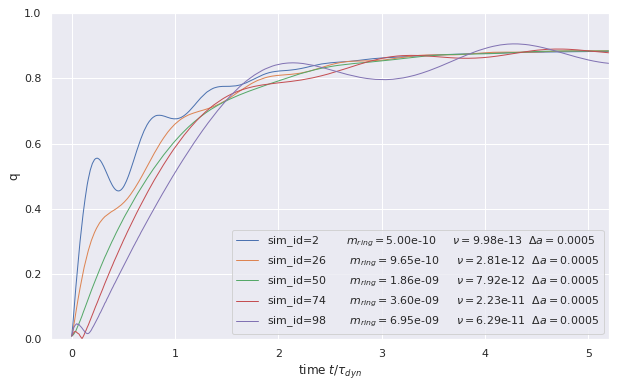

In [8]:
#for each total_ring_mass, plot q(t/t_dyn) for the sim whose viscosity yielded lowest delta_q
df = df_results
xlim = (-0.2, 5.2)
ylim = (0.0, 1.0)
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
total_ring_masses = df.total_ring_mass.sort_values().unique()
data = []
for total_ring_mass in total_ring_masses:
    #for each total_ring_mass, find the sim whose viscosity yields lowest delta_q
    idx = (df.current_timestep == df.expected_timestep) & (df.total_ring_mass == total_ring_mass) \
        & (df.wt_prime.abs() < df.q/2)
    dfs = df[idx]
    try:
        idx = dfs.delta_q.idxmin()
        dfss = dfs.loc[idx]
        path = dfss.path
        sim_id = dfss.sim_id
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
        dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0005)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot e_prime wt_prime and q versus time
        x = times_dynamical
        y = q
        sim_id_str = str(sim_id)
        label = 'sim_id=' + sim_id_str
        label += '\t' + r'$m_{ring}=$' + '{:.2e}'.format(total_ring_mass)
        label += '\t' + r'$\nu=$' + '{:.2e}'.format(shear_viscosity)
        label += '\t' + r'$\Delta a =$' + str(radial_width)
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=label)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('q')
        p = ax.set_xlim(xlim)
        p = ax.set_ylim(ylim)
        p = ax.legend()
        data += [dfss.to_dict()]
    except:
        pass
mass_viscosity = pd.DataFrame(data).sort_values('shear_viscosity')

In [9]:
#mass_viscosity
df_results.head()

sim_id  expected_timestep  current_timestep  streamline_crossing_timestep  \
0       0            1649000            989400                      935972.0   
1       1            1168000            992800                      959247.0   
2       2             826000            826000                           NaN   
3       3             585000            585000                           NaN   
4       4             414000            414000                           NaN   

   times_dynamical_max  total_ring_mass  radial_width  shear_viscosity  \
0                    5     5.000000e-10        0.0005     5.000000e-13   
1                    8     5.000000e-10        0.0005     7.062688e-13   
2                    9     5.000000e-10        0.0005     9.976312e-13   
3                    9     5.000000e-10        0.0005     1.409191e-12   
4                    9     5.000000e-10        0.0005     1.990536e-12   

          q   delta_q  wt_prime  \
0  0.878153  0.001383 -0.122961   
1  0.882915  0.000239 -0.130294   
2  0.885024  0.000112 -0.140323   
3  0.886415  0.000133 -0.154222   
4  0.887340  0.000182 -0.173519   

                                                path  
0  permutations/total_ring_mass=4.999999999999994...  
1  permutations/total_ring_mass=4.999999999999994...  
2  permutations/total_ring_mass=4.999999999999994...  
3  permutations/total_ring_mass=4.999999999999994...  
4  permutations/total_ring_mass=4.999999999999994...

coeffs =  [ 0.63492063 -3.87140174]
power_law exponent =  0.666666666667


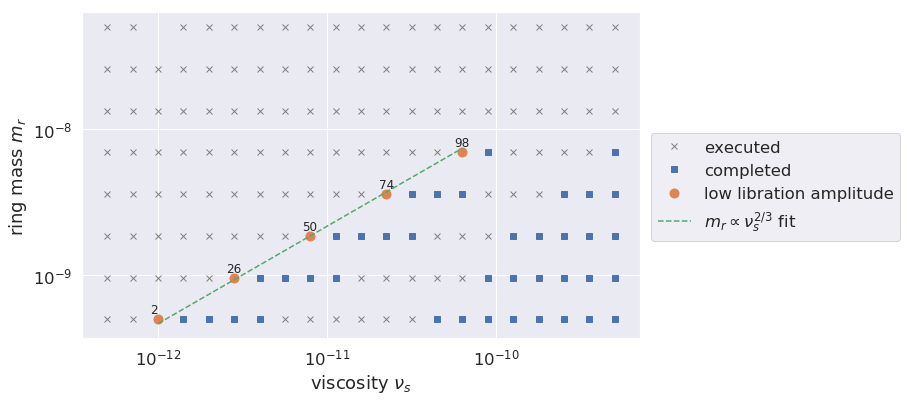

In [10]:
#show simulation outcomes
df = df_results
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
#indicate sims that didnt complete
idx = (df.current_timestep < df.expected_timestep)
dfs = df[idx]
xp = dfs.shear_viscosity
yp = dfs.total_ring_mass
p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=6, color='grey', label='executed')
#indicate sims that completed
idx = (df.current_timestep == df.expected_timestep)
dfs = df[idx]
xp = dfs.shear_viscosity
yp = dfs.total_ring_mass
p = ax.plot(xp, yp, linestyle='none', marker='s', markersize=6, label='completed')
#low libration sims
df = mass_viscosity
xp = df.shear_viscosity.values
yp = df.total_ring_mass.values
sim_id = df.sim_id.astype(str).values
p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=9, label='low libration amplitude')
for idx, x in enumerate(xp):
    s = sim_id[idx]
    xy = (0.9*xp[idx], 1.1*yp[idx])
    p = ax.annotate(s, xy, fontsize=12)
#assume power_law = 2/3
xp_log = np.log(xp)
yp_log = np.log(yp)
coeffs = np.polyfit(xp_log, yp_log, 1)
print 'coeffs = ', coeffs
power_law = 2./3.
print 'power_law exponent = ', power_law
idx = len(xp)//2
yp_fit = yp[idx]*(xp/xp[idx])**power_law
p = ax.plot(xp, yp_fit, linestyle='dashed', label=r'$m_r\propto\nu_s^{2/3}$ fit')
p = ax.set_xscale('log')
p = ax.set_yscale('log')
p = ax.set_xlabel(r'viscosity $\nu_s$')
p = ax.set_ylabel(r'ring mass $m_r$')
p = ax.legend(loc=(1.02, 0.3))

In [11]:
df = df_results
print 'total_ring_mass = ', df.total_ring_mass.unique()
print 'radial_width = ', df.radial_width.unique()
print 'shear_viscosity = ', df.shear_viscosity.unique()

total_ring_mass =  [5.00000000e-10 9.65348864e-10 1.86379686e-09 3.59842837e-09
 6.94747747e-09 1.34134790e-08 2.58973734e-08 5.00000000e-08]
radial_width =  [0.0005]
shear_viscosity =  [5.00000000e-13 7.06268772e-13 9.97631157e-13 1.40919147e-12
 1.99053585e-12 2.81170663e-12 3.97164117e-12 5.61009227e-12
 7.92446596e-12 1.11936057e-11 1.58113883e-11 2.23341796e-11
 3.15478672e-11 4.45625469e-11 6.29462706e-11 8.89139705e-11
 1.25594322e-10 1.77406695e-10 2.50593617e-10 3.53972892e-10
 5.00000000e-10]
